In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
import torch.optim as optim
from scipy import sparse as sp
import random
from graphviz import Graph
import pickle
import numpy as np
import heapq
import copy
import torch.nn.utils as torch_utils

import math
device = torch.device('cuda')

In [2]:
#seed 고정
seed = 1234
random.seed(seed)
np.random.seed(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(seed)
if device == 'cuda':
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
in_features =  1


def generate_random_weighted_graph(num_nodes, num_edges):
    # 방향 그래프 생성
    graph = nx.Graph()
    
    # 노드 추가
    nodes = range(num_nodes)
    graph.add_nodes_from(nodes)
    
    # 노드에 가중치 할당 및 노드 특징 벡터 생성
    x = torch.zeros(num_nodes, in_features)
    for node in graph.nodes:
        weight = random.uniform(0, 1)
        graph.nodes[node]['weight'] = weight
        x[node] = weight
    connected_nodes = set()
    start_node = random.choice(nodes)
    connected_nodes.add(start_node)
    for node in nodes:
        if node != start_node:
            graph.add_edge(start_node, node)
            connected_nodes.add(node)

    # 추가적인 랜덤 에지를 생성하여 num_edges를 충족
    additional_edges = num_edges - len(graph.edges)
    for _ in range(additional_edges):
        # 임의의 출발 노드와 도착 노드 선택
        source = random.choice(nodes)
        target = random.choice(nodes)
        
        if source == target or graph.has_edge(source, target):
            continue

        # 에지 추가
        graph.add_edge(source, target)

        # Generate v_prev tensor
    j = random.randint(0, num_nodes-1)

    adj_matrix = nx.adjacency_matrix(graph)
    adj_matrix_original = torch.Tensor(adj_matrix.todense())
    adj_matrix = adj_matrix + sp.eye(adj_matrix.shape[0]) # Add self-loop
    adj_tensor = torch.Tensor(adj_matrix.todense())
    adj_tensor = adj_tensor.unsqueeze(2)    
    return graph, x, adj_tensor, adj_matrix_original, j


num_graphs = 10
output_file = 'random_undirected_graphs.pkl'

graphs = []

for _ in range(num_graphs):
    num_nodes, num_edges = 50, np.random.randint(49,1225)
    graph, x, adj_tensor, adj_matrix_original, j= generate_random_weighted_graph(num_nodes, num_edges)
    next_nodes = []
    graphs.append((x, adj_tensor, j, adj_matrix_original, next_nodes))


# 그래프를 pickle 파일로 저장
with open(output_file, 'wb') as f:
    pickle.dump(graphs, f)

In [4]:
# pickle 파일에서 그래프 데이터 로드
with open('random_undirected_graphs.pkl', 'rb') as f:
    graphs = pickle.load(f)

In [46]:
# Encoder
class GraphAttentionLayer(torch.nn.Module):
    def __init__(self, in_features, out_features, n_heads, is_concat = True, dropout = 0.6, leacky_relu_negative_slope = 0.2):
        super(GraphAttentionLayer, self).__init__()
        self.W = torch.nn.Parameter(torch.randn(in_features, out_features), requires_grad = True)
        self.is_concat = is_concat
        self.n_heads = n_heads

        if is_concat:
            assert out_features % n_heads == 0

            self.n_hidden = out_features // n_heads
        else:
            self.n_hidden = out_features

        self.linear = nn.Linear(in_features, self.n_hidden * n_heads, bias = False)

        self.attn = nn.Linear(self.n_hidden * 2, 1, bias = False)
        self.activation = nn.LeakyReLU(negative_slope = leacky_relu_negative_slope)
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(dropout) 

    def forward(self, x, adj):
        n_nodes = x.shape[0]
        g=self.linear(x).view(n_nodes, self.n_heads, self.n_hidden)
        g_repeat = g.repeat(n_nodes, 1,1)
        g_repeat_interleave = g.repeat_interleave(n_nodes, dim=0)
        g_concat = torch.cat([g_repeat_interleave, g_repeat], dim = -1)
        g_concat = g_concat.view(n_nodes, n_nodes, self.n_heads, 2 * self.n_hidden)
        e = self.activation(self.attn(g_concat))
        e = e.squeeze(-1)
        adj = adj.repeat(1, 1, self.n_heads)
        assert adj.shape[0] == 1 or adj.shape[0] == n_nodes
        assert adj.shape[1] == 1 or adj.shape[1] == n_nodes
        assert adj.shape[2] == 1 or adj.shape[2] == self.n_heads
        e=e.masked_fill(adj == 0, 1)
        a = self.softmax(e)
        a = self.dropout(a)
        attn_res = torch.einsum('ijh,jhf->ihf', a, g)
        if self.is_concat:
            return attn_res.reshape(n_nodes, self.n_heads * self.n_hidden)
        else:
            attn_res = attn_res.mean(dim=1)
            return attn_res

class FeedForward(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, dropout=0.6):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(in_features, hidden_features)
        self.dropout1 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(hidden_features, out_features)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.dropout1(self.linear1(x)))
        x = self.dropout2(self.linear2(x))
        return x
# Decoder
class Decoder(torch.nn.Module):
    def __init__(self, in_features, hidden_features, out_features, n_heads, d_h):
        super(Decoder, self).__init__()
        self.n_heads = n_heads
        self.hidden_features = hidden_features
        self.d_h = d_h
        self.in_features = in_features

        # self.phi1 = torch.nn.Linear(d_h, 1)
        # self.phi2 = torch.nn.Linear(d_h, 1)
        self.phi1 = torch.nn.Linear(self.n_heads, self.hidden_features)     # TODO: input 차원 변경
        self.phi2 = torch.nn.Linear(self.n_heads, self.hidden_features)     # TODO: input 차원 변경
        self.softmax = nn.Softmax(dim=0)
        # self.C = torch.nn.Parameter(torch.randn(1))     # constant C
        self.C = 10     # constant C
        self.activation = nn.Tanh()

    def forward(self, output: torch.Tensor, prev_node: int, adj_modified: torch.Tensor):
        # output: N x d_h

        v_i = output[prev_node]     # d_h
        v_j = adj_modified     # N
        # prev_node와 인접한 노드의 feature만 필터링
        v_j = v_j.unsqueeze(1).cuda() * output      # N x d_h
        
        v_i = v_i.unsqueeze(0)      # 1 x d_h
        phi1_v_i = self.phi1(v_i)   # 1 x self.hidden_features
        phi2_v_j = self.phi2(v_j)   # N x self.hidden_features

        attn_input = torch.matmul(phi1_v_i, phi2_v_j.transpose(0, 1)) / (self.d_h ** 0.5)   # 1 x N

        attn_output = self.C * self.activation(attn_input)      # 1 x N

        attn_output = attn_output * adj_modified.to(device)     # 1 x N
        attn_output = attn_output.squeeze()

        attn_weights = self.softmax(attn_output)
        attn_weights = attn_weights * (attn_output != 0).float()

        p = attn_weights.max()
        selected_node = torch.argmax(attn_weights).item()

        return selected_node, p


class GAT(torch.nn.Module):
    def __init__(self, in_features, hidden_features, out_features, n_heads, d_h):
        super(GAT, self).__init__()
        self.n_heads = n_heads
        self.attention1 = GraphAttentionLayer(in_features, hidden_features, n_heads, is_concat = True, dropout = dropout)
        # self.norm= nn.LayerNorm(out_features)
        self.attention2 = GraphAttentionLayer(hidden_features, out_features, 1, is_concat = False, dropout = dropout)
        # self.norm= nn.LayerNorm(out_features)
        self.feed_forward = FeedForward(out_features, hidden_features, out_features, dropout)
        # self.norm= nn.LayerNorm(out_features)
        # self.batch_norm = nn.BatchNorm1d(out_features)
        self.decoder = Decoder(in_features, hidden_features, out_features, n_heads, d_h)
    
    def forward(self, x, adj):
        x = self.attention1(x, adj)
        x = self.attention2(x, adj)
        x = self.feed_forward(x)
        # x = self.norm(x)
        # x = self. batch_norm(x)
        x = F.softmax(x, dim=0) # softmax 쓴 이유
        return x
    
    def decode(self, output, i, adj_modified):
        return self.decoder(output, i, adj_modified)

In [67]:
def sync_model(target_model, source_model):     # baseline, gat_model
    target_model.load_state_dict(source_model.state_dict())


def decode_all(model, encoder_output, x, adj_matrix_original):
    n = encoder_output.size(0)  # node 갯수
    # visited_nodes = [0]
    visited_nodes = [random.randint(0,n-1)]    # next_node 값을 저장할 리스트 TODO: random
    branch_point = []
    possibilities = torch.empty(0).cuda()

    rewards = []
    accumulated_w = np.zeros(n)     # 수정
    accumulated_w[visited_nodes[0]] = 1.0    # 수정

    for i in range(n-1):
        prev_node = visited_nodes[i]
        row_indices = np.where(adj_matrix_original[:,prev_node] == 1)[0]
        row_indices = np.setdiff1d(row_indices, visited_nodes)

        if len(row_indices) >= 2:
            branch_point.append(prev_node)
        elif len(row_indices) == 0:
            while len(row_indices) == 0:
                if len(branch_point) == 0:
                    break
                prev_node = branch_point.pop()
                row_indices = np.where(adj_matrix_original[:,prev_node] == 1)[0]
                row_indices = np.setdiff1d(row_indices, visited_nodes)
                
                if len(row_indices) >= 2:
                    branch_point.append(prev_node)

        adj_modified = adj_matrix_original.clone()  # adj_matrix_original을 복사하여 새로운 행렬 생성

        # row_indices에 해당하는 인덱스를 1로 설정
        adj_modified[row_indices, :] = 1

        # row_indices에 해당하지 않는 인덱스를 0으로 설정
        other_indices = [i for i in range(adj_matrix_original.shape[0]) if i not in row_indices]
        adj_modified[other_indices, :] = 0
        adj_modified = adj_modified[:, 1]

        selected_node, p = model.decode(encoder_output, prev_node, adj_modified)


        # print("p", p)
        visited_nodes.append(selected_node)
        # print(i, 'visited nodes:', visited_nodes)
        possibilities = torch.cat([possibilities, p.unsqueeze(0)], dim=0)  # 텐서 합치기
        # print("possibilities", possibilities)

        # selected_node = visited_nodes[-1]
        accumulated_w[selected_node] = accumulated_w[prev_node] + x[selected_node].item()

        # calculate reward
        reward = accumulated_w.sum()
        rewards.append(reward)
    
    rewards = torch.Tensor(rewards)

    return visited_nodes, possibilities, rewards


In [68]:
n_heads = 8
hidden_features = 64
out_features = 8
d_h = 16 * n_heads
dropout = 0.6
n_epochs = 500

gat_model = GAT(in_features, hidden_features, out_features, n_heads, d_h).cuda()
optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.0001)

# baseline model
baseline_model = GAT(in_features, hidden_features, out_features, n_heads, d_h).cuda()
baseline_update_period = 40

In [71]:
def custom_loss(rewards, baseline_rewards, possibilities):
    rewards = rewards.cuda()
    baseline_rewards = baseline_rewards.cuda()
    possibilities = possibilities.cuda()
    return -((rewards - baseline_rewards) * torch.log(possibilities)).sum()

def train_step(model, optimizer, x, adj_tensor, baseline_model, baseline_update_period, output):
    model.train()  # 모델을 훈련 모드로 설정

    # output = model(x, adj_tensor)
    visited_nodes, possibilities, rewards = decode_all(model, output, x, adj_matrix_original)
    print(visited_nodes)

    # Baseline rollout
    with torch.no_grad():
        _, _, baseline_rewards = decode_all(baseline_model, output, x, adj_matrix_original)

    # Baseline model update
    if epoch % baseline_update_period == 0:
        sync_model(baseline_model, model)

    # 그래디언트 초기화
    optimizer.zero_grad()

    # Loss 계산
    loss = custom_loss(rewards, baseline_rewards, possibilities)

    # Backpropagation
    loss.requires_grad_(True)
    loss.backward(retain_graph=True)
    for name, param in gat_model.named_parameters():
        #print(f"name : {name}")
        # print(f"{name}: requires_grad= {param.requires_grad}")
        if param.grad is not None:
            print("Gradients")
            print(name, param.grad.norm())
    torch_utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
    optimizer.step()

    return loss.item()

In [73]:
# fig, axes = plt.subplots(len(graphs), 1, figsize=(8, 6*len(graphs)))
# loss_values = [[] for _ in range(len(graphs))]
torch.autograd.set_detect_anomaly(True)
# 훈련 루프에서 train_step 호출
for graph_idx, (x, adj_tensor, j, adj_matrix_original, _) in enumerate(graphs):
    x = x.cuda()
    adj_tensor = adj_tensor.cuda()

    output = gat_model(x, adj_tensor)
    
    for epoch in range(n_epochs):
        loss = train_step(gat_model, optimizer, x, adj_tensor, baseline_model, baseline_update_period, output)
        loss_values[graph_idx].append(loss)
        print(loss)

        for name, param in gat_model.named_parameters():
            # if param.requires_grad:
            #     print(name, param.data)
            if param.grad is not None:
                print("Gradients")
                print(name, param.grad.norm())

        # 그래프에 해당하는 서브플롯 생성
#         ax = axes[graph_idx] if len(graphs) > 1 else axes[0]
#         ax.plot(range(1, epoch+2), loss_values[graph_idx][:epoch+1], linestyle='-', linewidth=1)
#         ax.set_xlabel('Epoch')
#         ax.set_ylabel('Loss')
#         ax.set_title(f'Graph {graph_idx+1} Loss')

# plt.show()

[18, 23, 29, 33, 20, 39, 30, 42, 16, 48, 22, 24, 7, 32, 41, 26, 0, 3, 8, 1, 35, 21, 37, 44, 4, 43, 46, 6, 10, 28, 12, 9, 19, 36, 15, 25, 38, 13, 5, 34, 31, 17, 11, 27, 45, 47, 40, 49, 14, 2]
Gradients
attention1.linear.weight tensor(0.2042, device='cuda:0')
Gradients
attention1.attn.weight tensor(0.0068, device='cuda:0')
Gradients
attention2.linear.weight tensor(1.8751, device='cuda:0')
Gradients
attention2.attn.weight tensor(0.0004, device='cuda:0')
Gradients
feed_forward.linear1.weight tensor(0.7066, device='cuda:0')
Gradients
feed_forward.linear1.bias tensor(1.2182, device='cuda:0')
Gradients
feed_forward.linear2.weight tensor(3.8416, device='cuda:0')
Gradients
feed_forward.linear2.bias tensor(1.2530, device='cuda:0')
Gradients
decoder.phi1.weight tensor(28.2932, device='cuda:0')
Gradients
decoder.phi1.bias tensor(480.9001, device='cuda:0')
Gradients
decoder.phi2.weight tensor(29.7722, device='cuda:0')
Gradients
decoder.phi2.bias tensor(505.4634, device='cuda:0')
1469.053466796875
G

c:\Users\j\anaconda3\envs\39py\lib\site-packages\torch\autograd\__init__.py:173: UserWarning: Error detected in AddmmBackward0. Traceback of forward call that caused the error:
  File "c:\Users\j\anaconda3\envs\39py\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\j\anaconda3\envs\39py\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "c:\Users\j\anaconda3\envs\39py\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\j\anaconda3\envs\39py\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
    app.start()
  File "c:\Users\j\anaconda3\envs\39py\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
    self.io_loop.start()
  File "c:\Users\j\anaconda3\envs\39py\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "c:\Users\j\anaconda3\envs\39py\lib\async

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [64, 8]], which is output 0 of AsStridedBackward0, is at version 4; expected version 3 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

6151.9091796875
Gradients
attention1.linear.weight tensor(0.0002, device='cuda:0')
Gradients
attention1.attn.weight tensor(5.9379e-06, device='cuda:0')
Gradients
attention2.linear.weight tensor(0.0019, device='cuda:0')
Gradients
attention2.attn.weight tensor(1.7495e-06, device='cuda:0')
Gradients
feed_forward.linear1.weight tensor(0.0002, device='cuda:0')
Gradients
feed_forward.linear1.bias tensor(0.0012, device='cuda:0')
Gradients
feed_forward.linear2.weight tensor(0.0046, device='cuda:0')
Gradients
feed_forward.linear2.bias tensor(0.0016, device='cuda:0')
Gradients
decoder.phi1.weight tensor(0.0406, device='cuda:0')
Gradients
decoder.phi1.bias tensor(0.7254, device='cuda:0')
Gradients
decoder.phi2.weight tensor(0.0384, device='cuda:0')
Gradients
decoder.phi2.bias tensor(0.6860, device='cuda:0')
-841.2168579101562


c:\Users\j\anaconda3\envs\39py\lib\site-packages\torch\autograd\__init__.py:173: UserWarning: Error detected in AddmmBackward0. Traceback of forward call that caused the error:
  File "c:\Users\j\anaconda3\envs\39py\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\j\anaconda3\envs\39py\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "c:\Users\j\anaconda3\envs\39py\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\j\anaconda3\envs\39py\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
    app.start()
  File "c:\Users\j\anaconda3\envs\39py\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
    self.io_loop.start()
  File "c:\Users\j\anaconda3\envs\39py\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "c:\Users\j\anaconda3\envs\39py\lib\async

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [64, 8]], which is output 0 of AsStridedBackward0, is at version 2; expected version 1 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

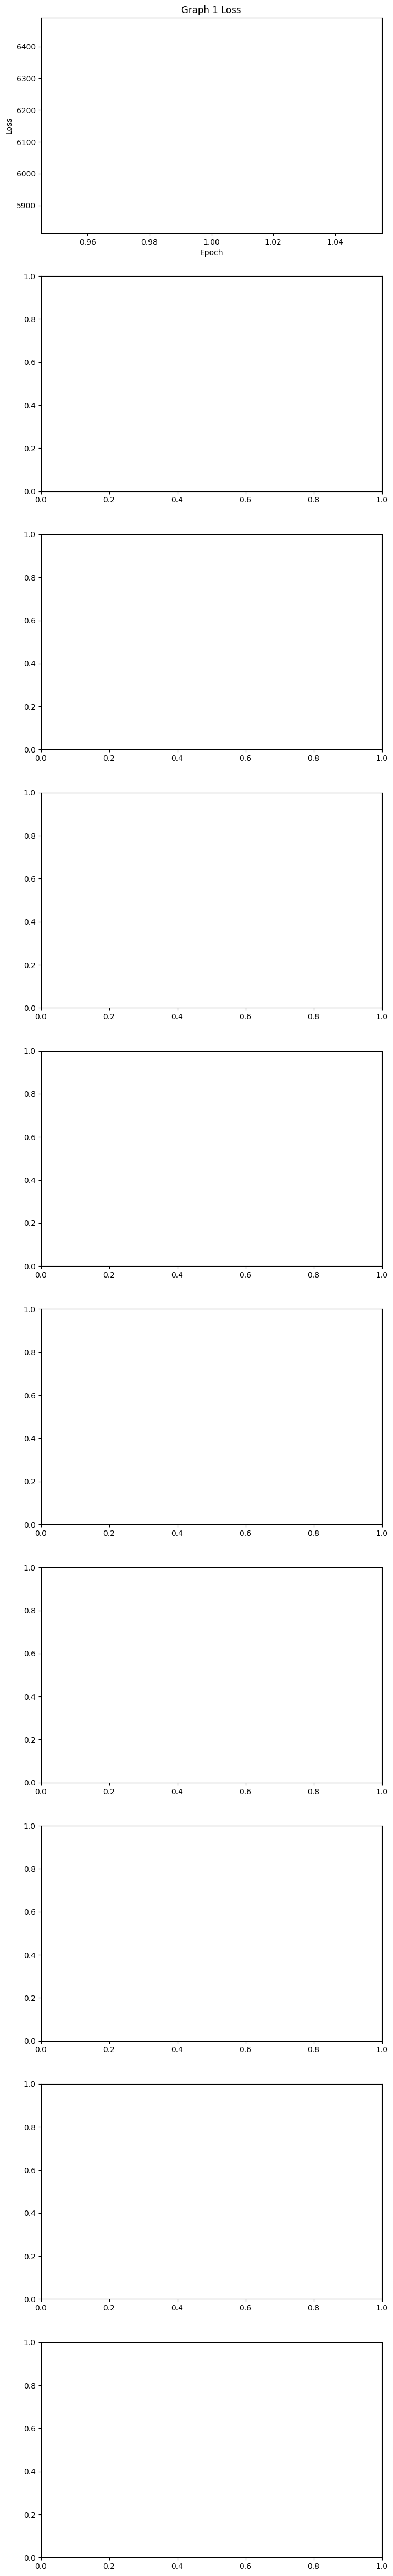

In [77]:
n_heads = 8
hidden_features = 64
out_features = 8
d_h = 16 * n_heads
dropout = 0.6
n_epochs = 500

gat_model = GAT(in_features, hidden_features, out_features, n_heads, d_h).cuda()
optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.5)

# baseline model
baseline_model = GAT(in_features, hidden_features, out_features, n_heads, d_h).cuda()
baseline_update_period = 40

fig, axes = plt.subplots(len(graphs), 1, figsize=(8, 6*len(graphs)))
loss_values = [[] for _ in range(len(graphs))]

for graph_idx, (x, adj_tensor, j, adj_matrix_original, _) in enumerate(graphs):
    x = x.cuda()
    adj_tensor = adj_tensor.cuda()

    # output_baseline = gat_model(x, adj_tensor)
    output = gat_model(x, adj_tensor)

    for epoch in range(n_epochs):
        # Decoder iteration
        visited_nodes, possibilities, rewards = decode_all(gat_model, output, x, adj_matrix_original)

        # Baseline rollout
        with torch.no_grad():
            _, _, baseline_rewards = decode_all(baseline_model, output, x, adj_matrix_original)
            # baseline_rewards_copy = baseline_rewards.clone()
        # for name, param in gat_model.named_parameters():
        #     print("gat_model.parameters()", name, param.data, param.requires_grad)
        # for name, param in baseline_model.named_parameters():
        #     print("baseline_model.parameters()", name, param.shape, param.requires_grad)

        # Baseline model update
        if epoch % baseline_update_period == 0:
            sync_model(baseline_model, gat_model)

        #그래디언트 초기화    
        optimizer.zero_grad()

        # Loss
        loss = custom_loss(rewards, baseline_rewards, possibilities)
        loss_values[graph_idx].append(loss.item())
        print(loss.item())

        # Backpropagation
        # optimizer.zero_grad()
        loss.requires_grad_(True)
        loss.backward(retain_graph = True)
        torch_utils.clip_grad_norm_(gat_model.parameters(), max_norm=1.0)
        optimizer.step()

        for name, param in gat_model.named_parameters():
            if param.grad is not None:
                print("Gradients")
                print(name, param.grad.norm())

        # 그래프에 해당하는 서브플롯 생성
        ax = axes[graph_idx] if len(graphs) > 1 else axes[0]
        ax.plot(range(1, epoch+2), loss_values[graph_idx][:epoch+1], linestyle='-', linewidth=1)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title(f'Graph {graph_idx+1} Loss')

#그림을 파일로 저장
plt.savefig(f'figure_epoch{n_epochs}.png')

plt.show()

In [7]:
'''search_space = {
    'hidden_features': [16, 32, 64],
    'n_heads': [2, 4, 8],
    'dropout': [0.5, 0.6, 0.7],
    'learning_rate': [0.0001, 0.001, 0.01]
}

best_loss = -float('inf')
best_params = None

for _ in range(10):  # Number of random search iterations
    # Sample random hyperparameters
    params = {
        'hidden_features': random.choice(search_space['hidden_features']),
        'n_heads': random.choice(search_space['n_heads']),
        'dropout': random.choice(search_space['dropout']),
        'learning_rate': random.choice(search_space['learning_rate'])
    }

    # Set the hyperparameters
    hidden_features = params['hidden_features']
    n_heads = params['n_heads']
    dropout = params['dropout']
    out_features = n_heads
    d_h = 4 * n_heads
    n_epochs = 100

    # baseline model
    baseline_model = GAT(in_features, hidden_features, out_features, n_heads, d_h).cuda()
    baseline_update_period = 10

    fig, axes = plt.subplots(len(graphs), 1, figsize=(8, 6*len(graphs)))
    loss_values = [[] for _ in range(len(graphs))]

    # Create a new GAT model
    gat_model = GAT(in_features, hidden_features, out_features, n_heads, d_h).cuda()
    optimizer = torch.optim.Adam(gat_model.parameters(), lr=params['learning_rate'])


    for epoch in range(n_epochs):
        for graph_idx, (x, adj_tensor, j, adj_matrix_original, _) in enumerate(graphs):
            x = x.cuda()
            adj_tensor = adj_tensor.cuda()

            output = gat_model(x, adj_tensor)

            # Decoder iteration
            visited_nodes, possibilities, rewards = decode_all(gat_model, output, x, adj_matrix_original)
            # print(visited_nodes)

            # Baseline rollout
            with torch.no_grad():
                _, _, baseline_rewards = decode_all(baseline_model, output, x, adj_matrix_original)

            # Baseline model update
            if epoch % baseline_update_period == 0:
                sync_model(baseline_model, gat_model)

            # Loss
            loss = -((rewards - baseline_rewards) * torch.log(possibilities)).sum()
            loss_values[graph_idx].append(loss.item())
            print('loss:', loss.item())

            # 그래프에 해당하는 서브플롯 생성
            ax = axes[graph_idx] if len(graphs) > 1 else axes[0]
            ax.plot(range(1, epoch+2), loss_values[graph_idx][:epoch+1], linestyle='-', linewidth=1)
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Loss')
            ax.set_title(f'Graph {graph_idx+1} Loss')

            # Backpropagation
            loss.requires_grad_(True)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Calculate the loss and update the best parameters
            if loss.item() > best_loss:
                best_loss = loss.item()
                best_params = params.copy()'''

"search_space = {\n    'hidden_features': [16, 32, 64],\n    'n_heads': [2, 4, 8],\n    'dropout': [0.5, 0.6, 0.7],\n    'learning_rate': [0.0001, 0.001, 0.01]\n}\n\nbest_loss = -float('inf')\nbest_params = None\n\nfor _ in range(10):  # Number of random search iterations\n    # Sample random hyperparameters\n    params = {\n        'hidden_features': random.choice(search_space['hidden_features']),\n        'n_heads': random.choice(search_space['n_heads']),\n        'dropout': random.choice(search_space['dropout']),\n        'learning_rate': random.choice(search_space['learning_rate'])\n    }\n\n    # Set the hyperparameters\n    hidden_features = params['hidden_features']\n    n_heads = params['n_heads']\n    dropout = params['dropout']\n    out_features = n_heads\n    d_h = 4 * n_heads\n    n_epochs = 100\n\n    # baseline model\n    baseline_model = GAT(in_features, hidden_features, out_features, n_heads, d_h).cuda()\n    baseline_update_period = 10\n\n    fig, axes = plt.subplots(l

In [8]:
'''print("Best Parameters: ", best_params)
print("Best Loss:", best_loss)'''

'print("Best Parameters: ", best_params)\nprint("Best Loss:", best_loss)'

참고
https://chioni.github.io/posts/gat/

수정 사항 : 
1. graph node 수 1,000개, edge 999 ~ 2000개로 random하게 뽑는 작업
2. loss값 그래프로 표현
3. loss의 경우 nan값이 나와서 이를 해결하기위해 possibilities 값을 뽑는 부분 수정 (pop하는 부분에서 오류가 발생해서 해당 코드 수정)
4. node_weight 의 범위 0에서 1로 설정

7/12 수정사항:
1. 노드 수 임시로 50개로 줄이기
2. 여전히 loss값에 inf가 나와서 다시 확인해 본 결과, row_indices를 정하는 부분에 오류를 발견 --> 수정
3. 시작 node를 random으로 바꿔주는 작업
4. best param 찾기(random search방법) --> 'hidden_features': 32, 'n_heads': 2, 'dropout': 0.7, 'learning_rate': 0.0001
5. epoch수 수정
    1) 400 -> 10분 44초 소요, 발산
    2) 600 -> 16분 38초 소요, 발산
    3) 800 -> 22분 36초 소요, 발산
    4) 1,000 -> 27분 42초 소요, 발산
    5) 2,000 -> 56분 3초 소요, 발산
    6) 3,000 -> 84분 42초 소요, 발산
    7) 4,000 -> 112분 초 소요, 발산
    8) 5,000 -> 156분 초 소요, 발산
    9) 10,000 -> 358분 초 소요, 발산